# 1. Data

In [1]:
import os, pathlib
import numpy as np
import pandas as pd

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}
INPUT_ROOT = "/kaggle/input"

def norm_path(p: str) -> str:
    # chuẩn hoá: lower + forward slash
    return pathlib.PurePosixPath(p).as_posix().lower()

# SỬA 1: dùng id 0,1,2 khác nhau
# SỬA 2: match_substrings là LIST
# SỬA 3: mình đưa s qua norm_path để so sánh cùng định dạng
LABELS = {
    0: {
        "name": "BunBo",
        "match_substrings": [
            "/kaggle/input/vietnamese-foods/images/test/bun bo hue",
            "/kaggle/input/vietnamese-foods/images/train/bun bo hue",
            "/kaggle/input/vietnamese-foods/images/validate/bun bo hue",
        ],
    },
    1: {
        "name": "BunRieu",
        "match_substrings": [
            "/kaggle/input/vietnamese-foods/Images/Test/Bun rieu",
            "/kaggle/input/vietnamese-foods/Images/train/Bun rieu",
            "/kaggle/input/vietnamese-foods/Images/validate/Bun rieu",
        ],
    },
    2: {
        "name": "BunMam",
        "match_substrings": [
            "/kaggle/input/vietnamese-foods/images/test/bun mam",
            "/kaggle/input/vietnamese-foods/images/train/bun mam",
            "/kaggle/input/vietnamese-foods/images/validate/bun mam",
        ],
    },
}

# 2) Thu thập ảnh chỉ từ các đường dẫn khớp
records = []
seen_paths = set()

ALL_SUBS = []
for lid, info in LABELS.items():
    for s in info["match_substrings"]:
        ALL_SUBS.append((lid, info["name"], norm_path(s)))  # chuẩn hoá luôn ở đây

for root, dirs, files in os.walk(INPUT_ROOT):
    root_norm = norm_path(root)

    # bỏ qua nhánh không liên quan để nhanh hơn
    if not any(sub in root_norm for _, _, sub in ALL_SUBS):
        continue

    for fn in files:
        ext = os.path.splitext(fn)[1].lower()
        if ext not in IMG_EXTS:
            continue

        fpath = os.path.join(root, fn)
        fpath_norm = norm_path(fpath)

        # xác định label theo "substring dài nhất"
        matched = []
        for lid, lname, sub in ALL_SUBS:
            if sub in fpath_norm:
                matched.append((len(sub), lid, lname))
        if not matched:
            continue

        matched.sort(reverse=True)              # ưu tiên sub dài nhất
        _, lid, lname = matched[0]

        if fpath in seen_paths:
            continue
        seen_paths.add(fpath)

        records.append({
            "path": fpath,
            "label_id": lid,
            "label_name": LABELS[lid]["name"],
        })

def infer_split(p: str):
    p = pathlib.PurePosixPath(p).as_posix().lower()
    # hỗ trợ nhiều biến thể
    if "/train/" in p or "/images/train/" in p:
        return "train"
    if "/val/" in p or "/valid/" in p or "/validate/" in p or "/images/validate/" in p:
        return "val"
    if "/test/" in p or "/images/test/" in p:
        return "test"
    return "unknown"

df = pd.DataFrame(records)
print("Tổng số ảnh lấy được:", len(df))
print(df.groupby(["label_id","label_name"]).size())# Lưu DataFrame ra CSV



df["split"] = df["path"].apply(infer_split)

# Ép kiểu label_id về int (nếu đang là str)
df["label_id"] = pd.to_numeric(df["label_id"], errors="raise").astype(int)

out_csv = "/kaggle/working/vietnamese_foods_meta.csv"
df.to_csv(out_csv, index=False, encoding="utf-8-sig")

print("Đã lưu metadata vào:", out_csv)

Tổng số ảnh lấy được: 3454
label_id  label_name
0         BunBo         1530
1         BunRieu       1151
2         BunMam         773
dtype: int64
Đã lưu metadata vào: /kaggle/working/vietnamese_foods_meta.csv


# 2. Preprocess 

In [2]:
import os, math, pathlib, random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

RANDOM_SEED = 2024
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

WORKING_DIR = "/kaggle/working"
CSV_META = f"{WORKING_DIR}/vietnamese_foods_meta.csv"  # hoặc meta bạn vừa tạo
df = pd.read_csv(CSV_META)

# Nếu chưa có cột split, tự suy ra từ đường dẫn (train/val/test)
if "split" not in df.columns:
    def infer_split(p: str):
        p = pathlib.PurePosixPath(p).as_posix().lower()
        if "/train/" in p: return "train"
        if "/validate/" in p or "/val/" in p: return "val"
        if "/test/" in p: return "test"
        return "unknown"
    df["split"] = df["path"].apply(infer_split)

# Bảo đảm có label_name để vẽ đẹp
if "label_name" not in df.columns and "label_id" in df.columns:
    # fallback gán theo label_id
    df["label_name"] = df["label_id"].astype(str)

print(df.head())
print(df["split"].value_counts())
print(df.groupby("label_name").size().sort_values(ascending=False))


                                                path  label_id label_name  \
0  /kaggle/input/vietnamese-foods/Images/Validate...         2     BunMam   
1  /kaggle/input/vietnamese-foods/Images/Validate...         2     BunMam   
2  /kaggle/input/vietnamese-foods/Images/Validate...         2     BunMam   
3  /kaggle/input/vietnamese-foods/Images/Validate...         2     BunMam   
4  /kaggle/input/vietnamese-foods/Images/Validate...         2     BunMam   

  split  
0   val  
1   val  
2   val  
3   val  
4   val  
split
train    2417
test      692
val       345
Name: count, dtype: int64
label_name
BunBo      1530
BunRieu    1151
BunMam      773
dtype: int64


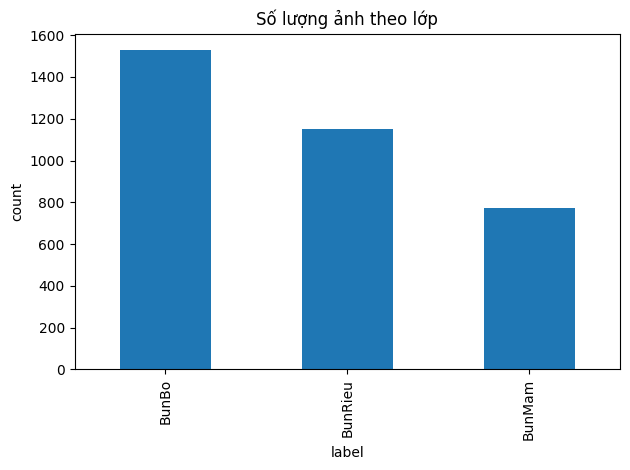

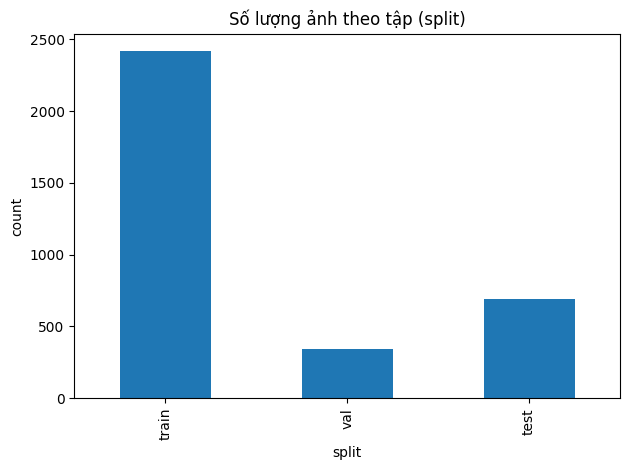

label_name  BunBo  BunMam  BunRieu
split                             
test          306     155      231
train        1071     541      805
val           153      77      115

<Figure size 640x480 with 0 Axes>

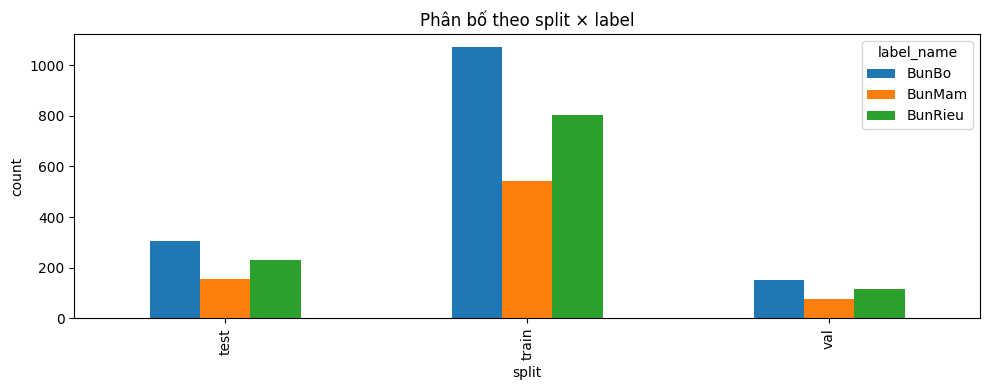

In [3]:
# Đếm theo lớp
plt.figure()
df["label_name"].value_counts().sort_values(ascending=False).plot(kind="bar")
plt.title("Số lượng ảnh theo lớp")
plt.xlabel("label"); plt.ylabel("count")
plt.tight_layout(); plt.show()

# Đếm theo split
plt.figure()
df["split"].value_counts().reindex(["train","val","test","unknown"]).dropna().plot(kind="bar")
plt.title("Số lượng ảnh theo tập (split)")
plt.xlabel("split"); plt.ylabel("count")
plt.tight_layout(); plt.show()

# Bảng chéo split × label
pivot = pd.pivot_table(df, index="split", columns="label_name", values="path", aggfunc="count").fillna(0)
display(pivot)
plt.figure()
pivot.plot(kind="bar", figsize=(10,4))
plt.title("Phân bố theo split × label")
plt.xlabel("split"); plt.ylabel("count")
plt.tight_layout(); plt.show()


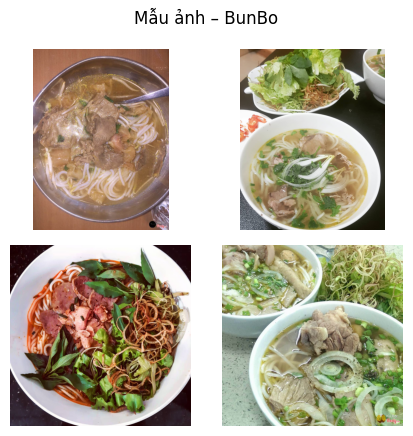

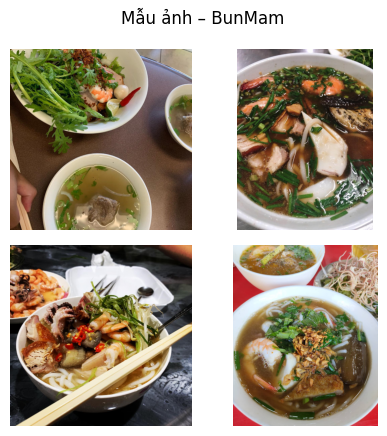

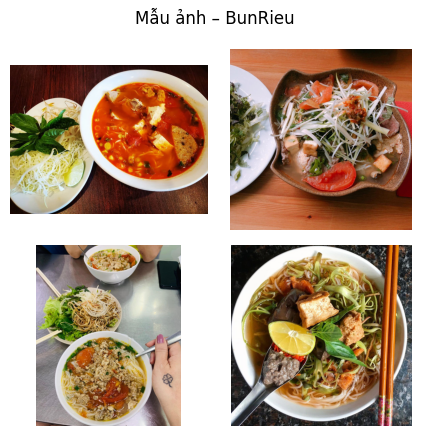

In [4]:
def show_random_grid(paths, title="", n=4):
    paths = list(paths)
    n = min(n, len(paths))
    if n == 0:
        print("Không có ảnh để hiển thị."); return
    sel = random.sample(paths, n)
    cols = max(1, int(math.sqrt(n)))
    rows = int(np.ceil(n/cols))

    plt.figure(figsize=(cols*2.2, rows*2.2))
    for i, p in enumerate(sel, 1):
        try:
            im = Image.open(p).convert("RGB")
            plt.subplot(rows, cols, i)
            plt.imshow(im); plt.axis("off")
        except Exception:
            pass
    plt.suptitle(title)
    plt.tight_layout(); plt.show()

# Lưới mẫu cho từng lớp (gộp tất cả split)
for label in sorted(df["label_name"].unique()):
    paths = df.loc[df["label_name"]==label, "path"]
    show_random_grid(paths, title=f"Mẫu ảnh – {label}", n=4)


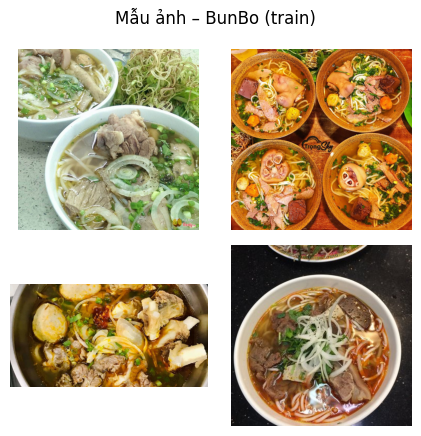

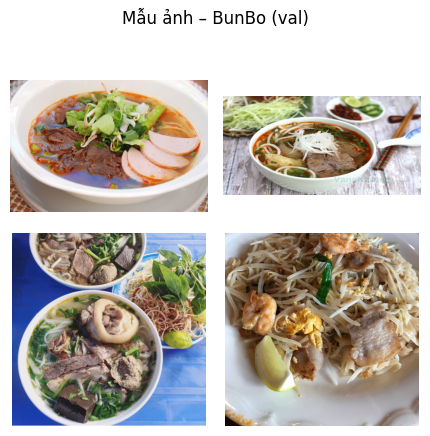

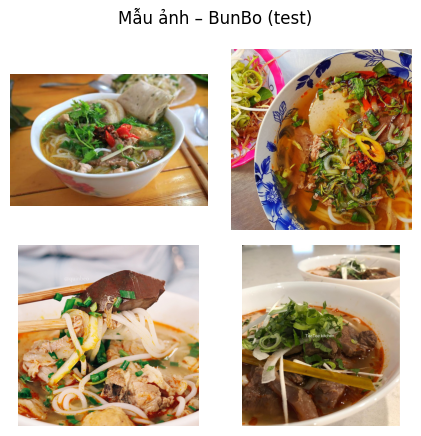

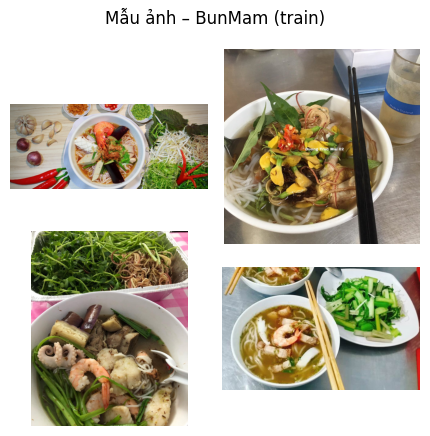

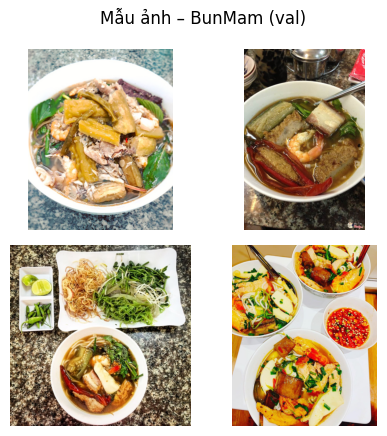

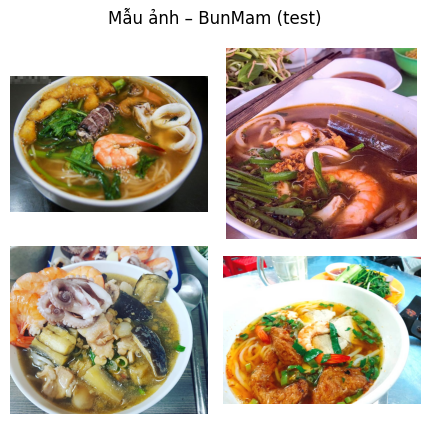

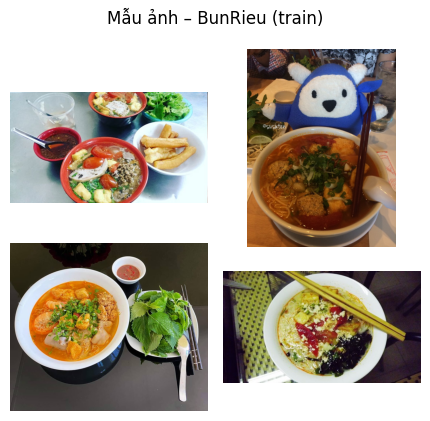

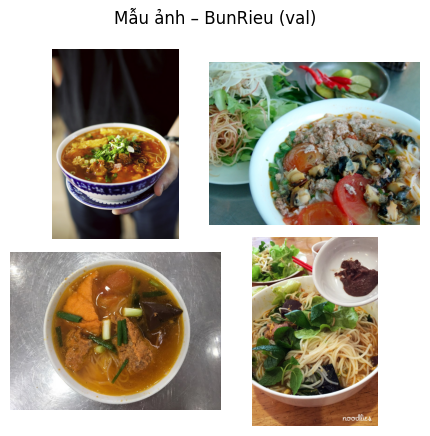

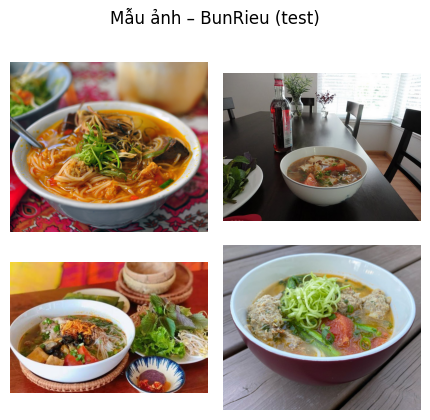

In [5]:
splits = ["train","val","test"]
for label in sorted(df["label_name"].unique()):
    for sp in splits:
        subset = df[(df["label_name"]==label) & (df["split"]==sp)]
        if subset.empty: 
            continue
        show_random_grid(subset["path"], title=f"Mẫu ảnh – {label} ({sp})", n=4)


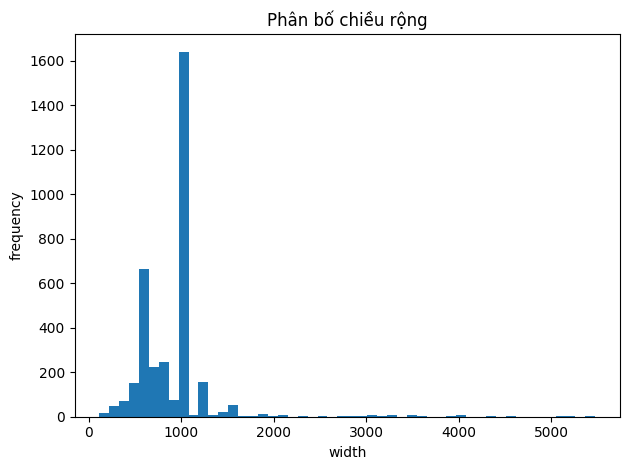

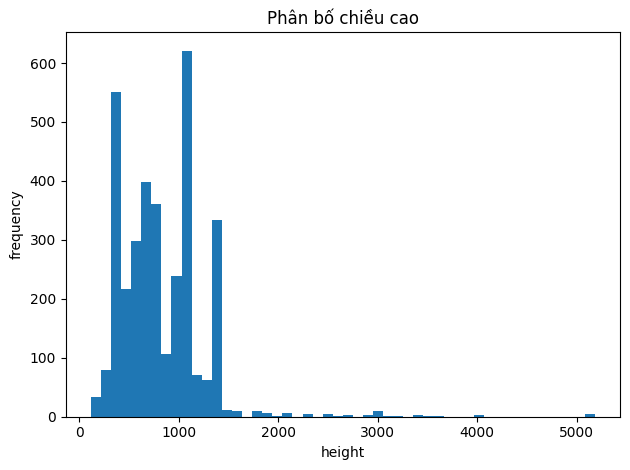

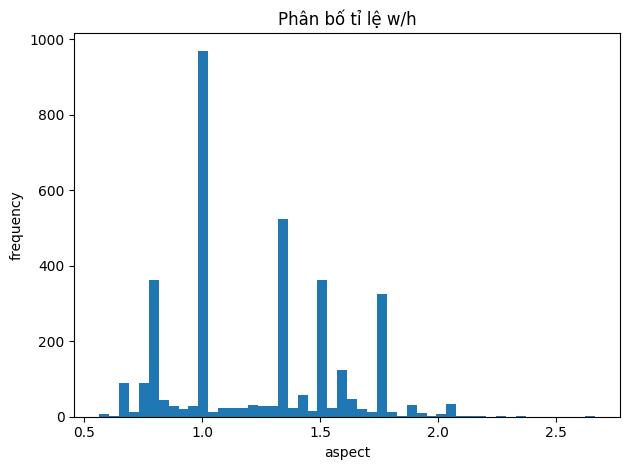

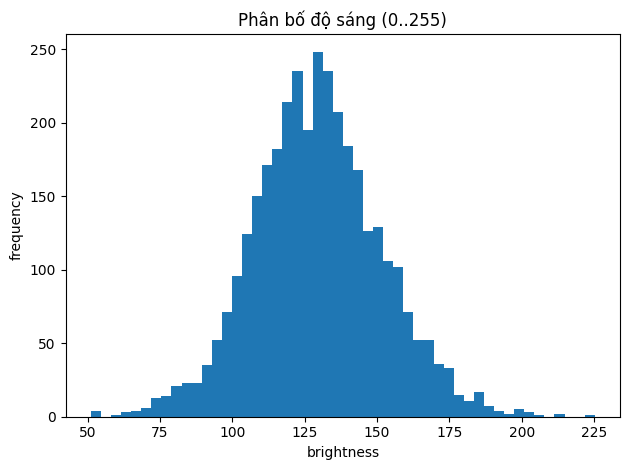

In [6]:
from PIL import ImageStat

def image_stats(path):
    try:
        with Image.open(path).convert("RGB") as im:
            w,h = im.size
            aspect = w/h if h else np.nan
            bright = float(ImageStat.Stat(im.convert("L")).mean[0])
            return w,h,aspect,bright
    except Exception:
        return np.nan,np.nan,np.nan,np.nan

if not {"width","height","aspect","brightness"}.issubset(df.columns):
    stats = df["path"].apply(image_stats)
    df["width"], df["height"], df["aspect"], df["brightness"] = zip(*stats)

for col, title in [
    ("width", "Phân bố chiều rộng"),
    ("height","Phân bố chiều cao"),
    ("aspect","Phân bố tỉ lệ w/h"),
    ("brightness","Phân bố độ sáng (0..255)")
]:
    vals = pd.to_numeric(df[col], errors="coerce").dropna().values
    if len(vals)==0: continue
    plt.figure()
    plt.hist(vals, bins=50)
    plt.title(title); plt.xlabel(col); plt.ylabel("frequency")
    plt.tight_layout(); plt.show()


In [7]:
# PyTorch pipeline: đọc từ CSV + augmentation cho train
import os, pathlib, random
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms

CSV_META = "/kaggle/working/vietnamese_foods_meta.csv"
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 0

df = pd.read_csv(CSV_META)

# Bảo đảm 3 cột: path, label_id, split
assert {"path","label_id","split"}.issubset(df.columns)

# Transforms: chỉ áp dụng nặng cho train
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0), ratio=(0.75, 1.33)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.03),
    transforms.RandomGrayscale(p=0.05),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.12), ratio=(0.3, 3.3), inplace=False),
])

val_tf = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
])

class FoodCSV(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["path"]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = int(row["label_id"])
        return img, label

train_df = df[df["split"].str.lower()=="train"].copy()
val_df   = df[df["split"].str.lower().isin(["val","valid"])].copy()
test_df  = df[df["split"].str.lower()=="test"].copy()

train_ds = FoodCSV(train_df, transform=train_tf)
val_ds   = FoodCSV(val_df,   transform=val_tf)
test_ds  = FoodCSV(test_df,  transform=val_tf)

# (tuỳ chọn) cân bằng dữ liệu bằng WeightedRandomSampler
cls_counts = train_df["label_id"].value_counts().to_dict()
num_classes = len(cls_counts)
class_weights = {c: len(train_df)/ (num_classes*cnt) for c,cnt in cls_counts.items()}
sample_weights = train_df["label_id"].map(class_weights).values

sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                           num_workers=NUM_WORKERS, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds), cls_counts


(2417, 345, 692, {0: 1071, 1: 805, 2: 541})

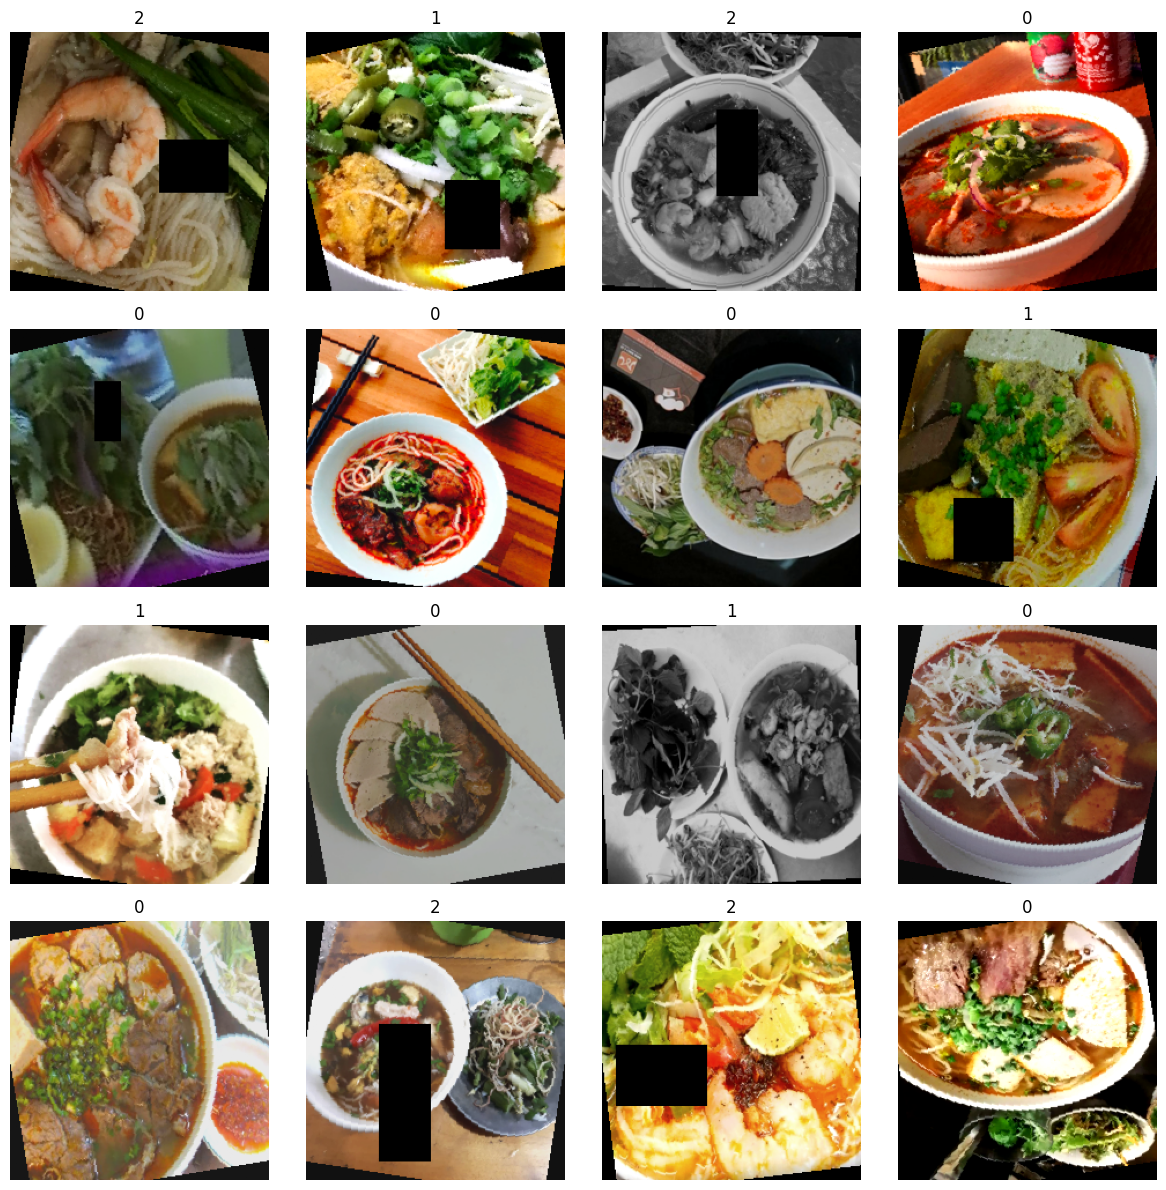

In [8]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))  # lấy 1 batch ngẫu nhiên từ train
n = min(16, images.size(0)); cols = 4; rows = (n + cols - 1)//cols
plt.figure(figsize=(cols*3, rows*3))
for i in range(n):
    plt.subplot(rows, cols, i+1)
    plt.imshow(images[i].permute(1,2,0).numpy().clip(0,1))
    plt.title(int(labels[i].item()))
    plt.axis("off")
plt.tight_layout(); plt.show()


# 3. CNN

In [9]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Device: cuda
GPU: Tesla P100-PCIE-16GB


In [10]:
import torch
import torch.nn as nn

# Suy ra số lớp từ df nếu có, nếu không mặc định 3 (BunBo, BunRieu, BunMam)
try:
    NUM_CLASSES = int(df["label_id"].nunique())
except:
    NUM_CLASSES = 3

class SimpleCNN(nn.Module):
    """
    CNN đơn giản:
      [Conv(3→32) → ReLU → MaxPool] →
      [Conv(32→64) → ReLU → MaxPool] →
      [Conv(64→128) → ReLU → MaxPool] →
      GAP (AdaptiveAvgPool2d) → FC(128→256) → ReLU → FC(256→C)
    - Dùng ReLU trong hidden
    - Softmax sẽ áp dụng ở suy luận; khi train dùng CrossEntropy (logits)
    """
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 224x224 → 224x224
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                              # → 112x112

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # → 112x112
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                              # → 56x56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),# → 56x56
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                              # → 28x28
        )
        self.gap = nn.AdaptiveAvgPool2d(1)               # → (128,1,1)
        self.classifier = nn.Sequential(
            nn.Flatten(),                                 # 128
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)                   # logits
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x  # logits (Softmax dùng khi inference)

model = SimpleCNN(num_classes=NUM_CLASSES).to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gap): AdaptiveAvgPool2d(output_size=1)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [11]:
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm.auto import tqdm
import numpy as np

EPOCHS = 30
lr = 3e-4
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()
    tot_loss, tot_correct, tot_n = 0.0, 0, 0
    for images, targets in tqdm(loader, disable=False):
        images, targets = images.to(device), targets.to(device)

        if train:
            optimizer.zero_grad()

        logits = model(images)                  # (B, C) logits
        loss = criterion(logits, targets)

        if train:
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            preds = logits.argmax(1)
            tot_correct += (preds == targets).sum().item()
            tot_n += targets.size(0)
            tot_loss += loss.item() * targets.size(0)

    avg_loss = tot_loss / max(1, tot_n)
    acc = tot_correct / max(1, tot_n)
    return avg_loss, acc

train_hist, val_hist = [], []
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader,   train=False)
    train_hist.append((tr_loss, tr_acc))
    val_hist.append((va_loss, va_acc))
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 01 | train loss 1.0975 acc 0.3554 | val loss 1.0893 acc 0.3333


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 02 | train loss 1.0900 acc 0.3893 | val loss 1.0780 acc 0.3681


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 03 | train loss 1.0701 acc 0.4170 | val loss 1.0543 acc 0.3681


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 04 | train loss 1.0682 acc 0.4170 | val loss 1.0563 acc 0.3768


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 05 | train loss 1.0575 acc 0.4261 | val loss 1.0478 acc 0.3826


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 06 | train loss 1.0643 acc 0.4191 | val loss 1.0418 acc 0.5246


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 07 | train loss 1.0509 acc 0.4406 | val loss 1.0151 acc 0.4551


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 08 | train loss 1.0340 acc 0.4675 | val loss 1.0453 acc 0.3652


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 09 | train loss 1.0340 acc 0.4584 | val loss 0.9985 acc 0.5159


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10 | train loss 1.0336 acc 0.4568 | val loss 0.9804 acc 0.5275


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11 | train loss 1.0241 acc 0.4799 | val loss 0.9793 acc 0.5565


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12 | train loss 1.0088 acc 0.4952 | val loss 0.9608 acc 0.5594


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13 | train loss 0.9924 acc 0.5205 | val loss 1.0406 acc 0.4290


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14 | train loss 1.0178 acc 0.4870 | val loss 1.0482 acc 0.4029


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15 | train loss 1.0026 acc 0.4866 | val loss 0.9422 acc 0.5739


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 16 | train loss 0.9744 acc 0.5321 | val loss 0.9433 acc 0.5594


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 17 | train loss 0.9846 acc 0.5134 | val loss 0.9321 acc 0.5826


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 18 | train loss 0.9596 acc 0.5449 | val loss 0.9412 acc 0.5768


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 19 | train loss 0.9876 acc 0.5250 | val loss 0.9427 acc 0.5391


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 20 | train loss 0.9776 acc 0.5362 | val loss 0.9164 acc 0.5913


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 21 | train loss 0.9505 acc 0.5515 | val loss 0.9404 acc 0.5681


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 22 | train loss 0.9777 acc 0.5205 | val loss 0.9220 acc 0.5913


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 23 | train loss 0.9571 acc 0.5519 | val loss 0.9017 acc 0.6203


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 24 | train loss 0.9664 acc 0.5412 | val loss 0.9870 acc 0.4928


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 25 | train loss 0.9475 acc 0.5548 | val loss 0.8800 acc 0.6232


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 26 | train loss 0.9419 acc 0.5478 | val loss 0.9183 acc 0.6000


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 27 | train loss 0.9510 acc 0.5490 | val loss 0.9025 acc 0.6058


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 28 | train loss 0.9589 acc 0.5350 | val loss 0.8791 acc 0.6058


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 29 | train loss 0.9348 acc 0.5536 | val loss 0.9016 acc 0.6232


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 30 | train loss 0.9263 acc 0.5664 | val loss 0.9542 acc 0.5594
